# SF Forecast Examples

## Contents

This notebook demonstrates how to employ sforecast (sliding/expanding window) to make forecast predictions using three types of models - classical forecast models, SK learn models such as XGBoost, and Tensorflow. 

Models are based on time existing implentations. For the case of SK Learn models and TensorFlow, the models are defined externally to sforecast and a reference to the model is passed into sforecast. For the classic models, the model parameters are passed into sforecast. 

The notebook demostrates examples for each these model types such as univariate and multivariate, exogenous variables, and several deep learning models, including the use of categorical embeddings, deep learning (hidden layers), and LSTMs.

The notebook demonstrates the mechanics of setting up and running the corresponding models and data. Mathematical or statistical discussions are out of scope of this notebook. 

1. Classic Models 
   * Arima
   * SARIMAX
   * Auto ARIMA  

2. SK Learn Models
   * Superstore Data
   * Transforming to Wide Data Format
   * Univariate with XGBoost
   * Multivariate with one output
   * Multivariate with and multiple outputs

3. TensorFlow Models
   * M5 Walmart Sales Data, 20 Items
   * Univariate Deep Learning Deep Learning
   * Univariate + Categorical Embeddings
   * Multivariate + Exogenous + Catigorical Embeddings and Multivariate Output 
   * Multivarate LSTM + Exogenous + Categorical Embeddngs and Multivariate Output

## Initialize Notebook

In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import numpy as np
import beautifulplots as bp
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from pandas.plotting import autocorrelation_plot

sforecast version = 0.1.0


## 1. Classic Models -  ARIMA, SARIMA, Auto_ARIMA

### ARIMA, Shampoo Sales

df_shampoo.shape = (36, 2)


,Month,Sales
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


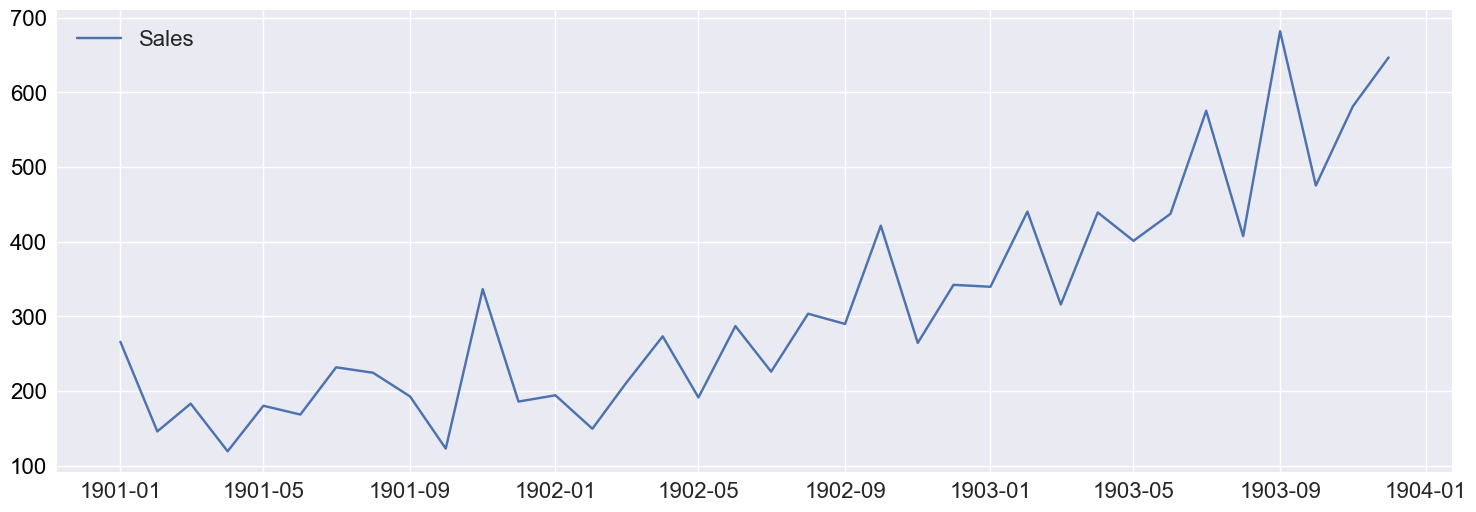

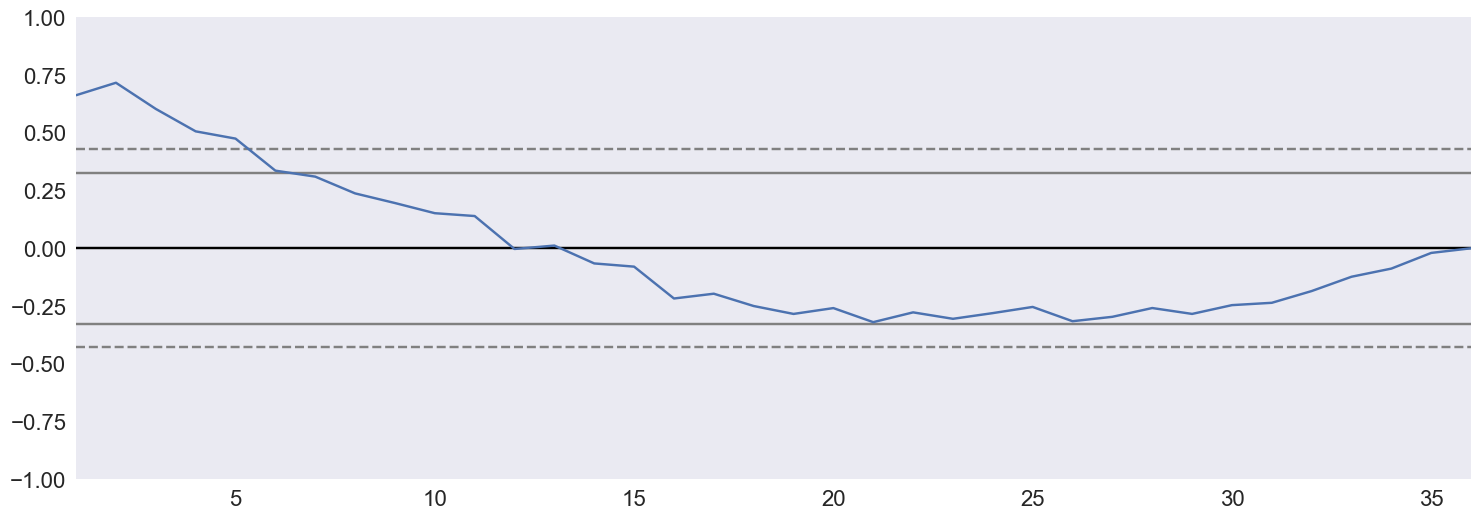

In [81]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ ... date parser and dataset
def dateparser(x):
    return datetime.strptime('190'+x, '%Y-%m')

df_shampoo = pd.read_csv("../data/shampoo.csv", parse_dates = ["Month"], date_parser=dateparser)
print("df_shampoo.shape =",df_shampoo.shape)
display(df_shampoo.head())
bp.lineplot(df_shampoo, x = "Month", y="Sales", figsize=(18,6), y_axis_format=".0f")

# Plot Sales Autocorrelation
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(18,6)) 
g=autocorrelation_plot(df_shampoo["Sales"])

plot_options = bp.plot_defaults()
bp.set_axisparams(plot_options,ax,g)
plt.show()


ARIMA sliding 5 period forecast

dfXY


,Month,Sales
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3



metrics = {'Sales_pred': {'RMSE': 96.4139361648774, 'MAE': 78.28000065334483}}


,Month,Sales,Sales_train,Sales_test,Sales_pred,Sales_pred_error,Sales_pred_lower,Sales_pred_upper
31,1903-08-01,407.6,NaN,407.6,467.811682,-60.211682,417.810777,614.513666
32,1903-09-01,682.0,NaN,682.0,519.261277,162.738723,469.260372,665.963261
33,1903-10-01,475.3,NaN,475.3,464.182016,11.117984,414.181112,610.884001
34,1903-11-01,581.3,NaN,581.3,615.984739,-34.684739,565.983834,762.686723
35,1903-12-01,646.9,NaN,646.9,524.253124,122.646876,474.252220,670.955109


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -193.715
Date:                Fri, 18 Nov 2022   AIC                            393.431
Time:                        13:49:08   BIC                            398.010
Sample:                             0   HQIC                           394.992
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8795      0.217     -4.050      0.000      -1.305      -0.454
ar.L2         -0.1750      0.204     -0.857      0.391      -0.575       0.225
sigma2      5078.3674   1317.188      3.855      0.0

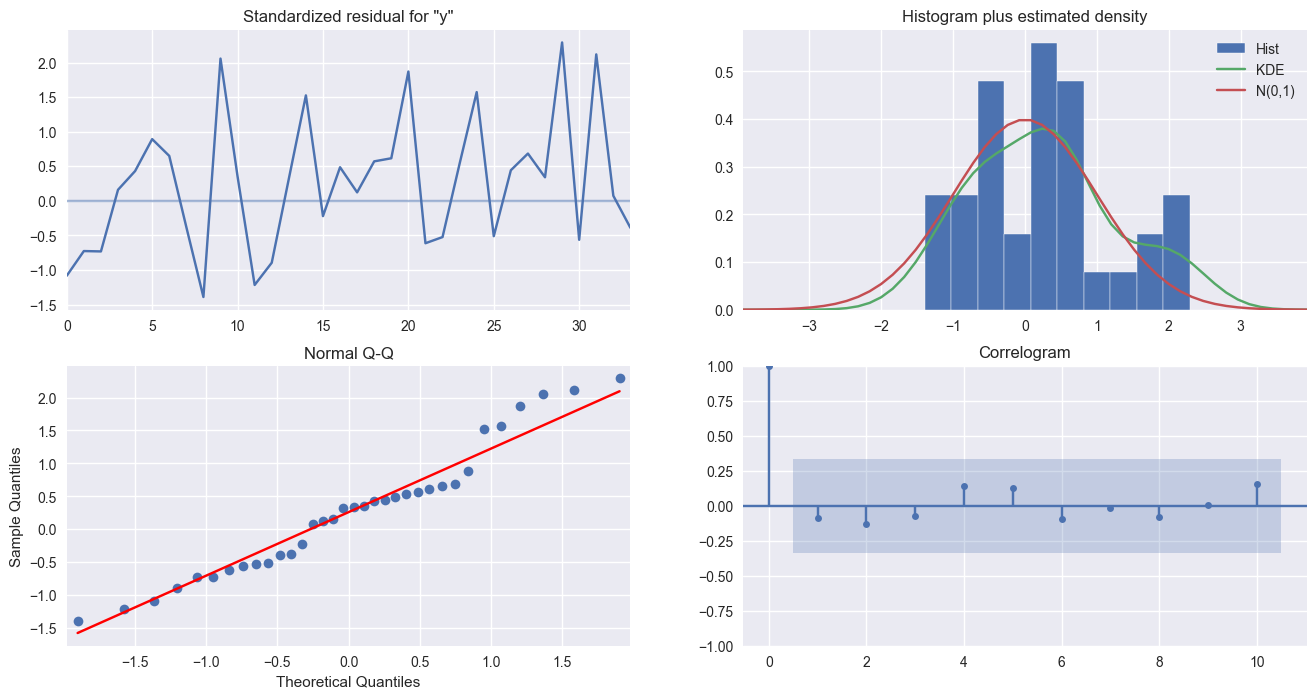

In [82]:
Npred=5
dfXY = df_shampoo
print('dfXY')
display(dfXY.head())

tswin_params = {
    "Npred":Npred,
    "Nlags":5,
    "minmax" :(0,None)}  

cm_parameters = {
    "model":"arima",
    "order":(2,1,0)
}

y = "Sales"
sf_arima = sf.sforecast(y = y, model=None,model_type="cm", cm_parameters=cm_parameters,
                    tswin_parameters=tswin_params,)

df_pred_arima = sf_arima.forecast(dfXY)


print(f'\nmetrics = {sf_arima.metrics}')
dfXY_pred_arima = dfXY.join(df_pred_arima)
display(dfXY_pred_arima.tail())

print(sf_arima.model_fit.summary())

sf_arima.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

plot observations and predictions with beautifulplots.lineplot

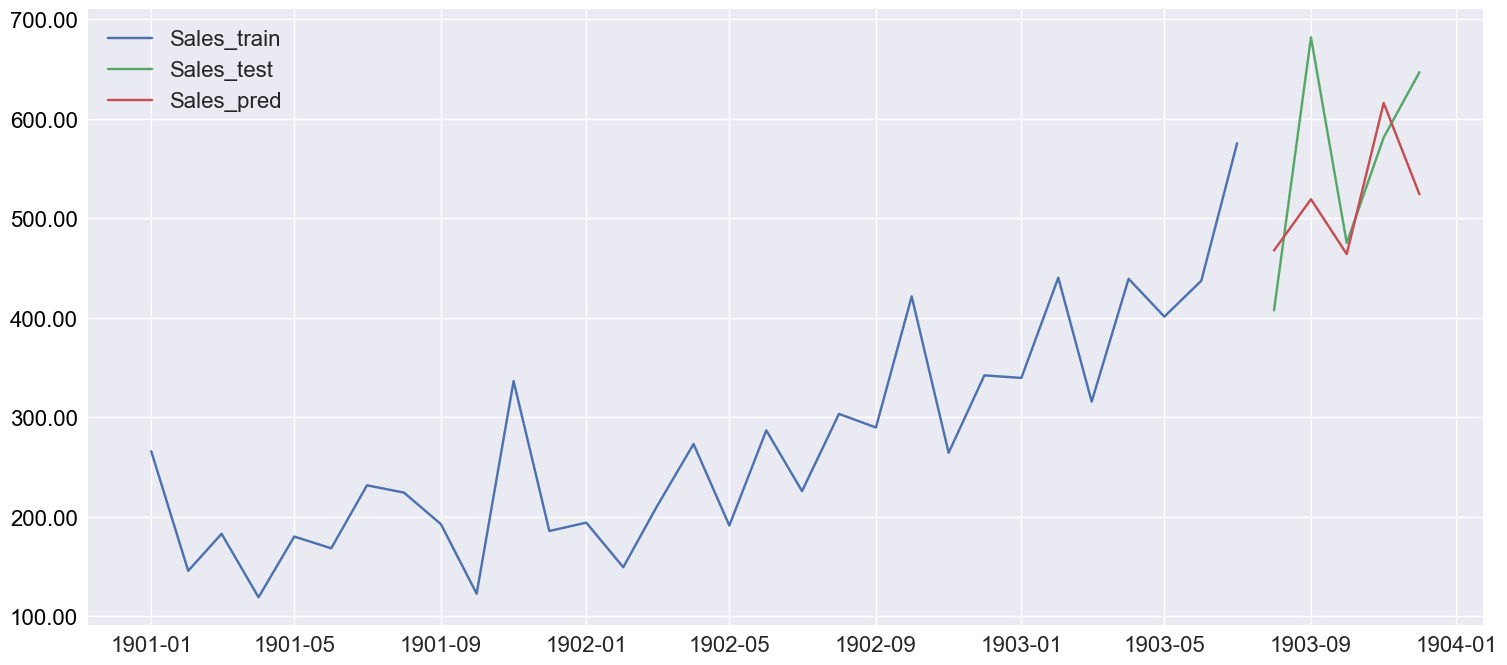

In [83]:
y =  "Sales" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfXY_pred_arima, x= "Month", y=[ytrain, ytest , ypred] , figsize=(18,8))

direct use of ARIMA for comparison (1 period forward forecast)

In [84]:
model = ARIMA(dfXY.iloc[:-1]['Sales'], order=(2,1,0)) # use all but the last observation for the fit
model_fit = model.fit()
y_pred=model_fit.forecast().values[0]
print("\ny_pred =",y_pred)
print("y_actual =",dfXY.tail(1)["Sales"].values[0])




y_pred = 524.253124387115
y_actual = 646.9


### SARIMAX

load data and observe

df_airp


,Passengers,ravg,rstd,month_no
Month,,,,
1950-01-01,115,126.916667,13.453342,1
1950-02-01,126,127.583333,13.166475,2
1950-03-01,141,128.333333,13.686977,3
1950-04-01,135,128.833333,13.822467,4
1950-05-01,125,129.166667,13.663710,5


rows with NA


,Passengers,ravg,rstd,month_no
Month,,,,


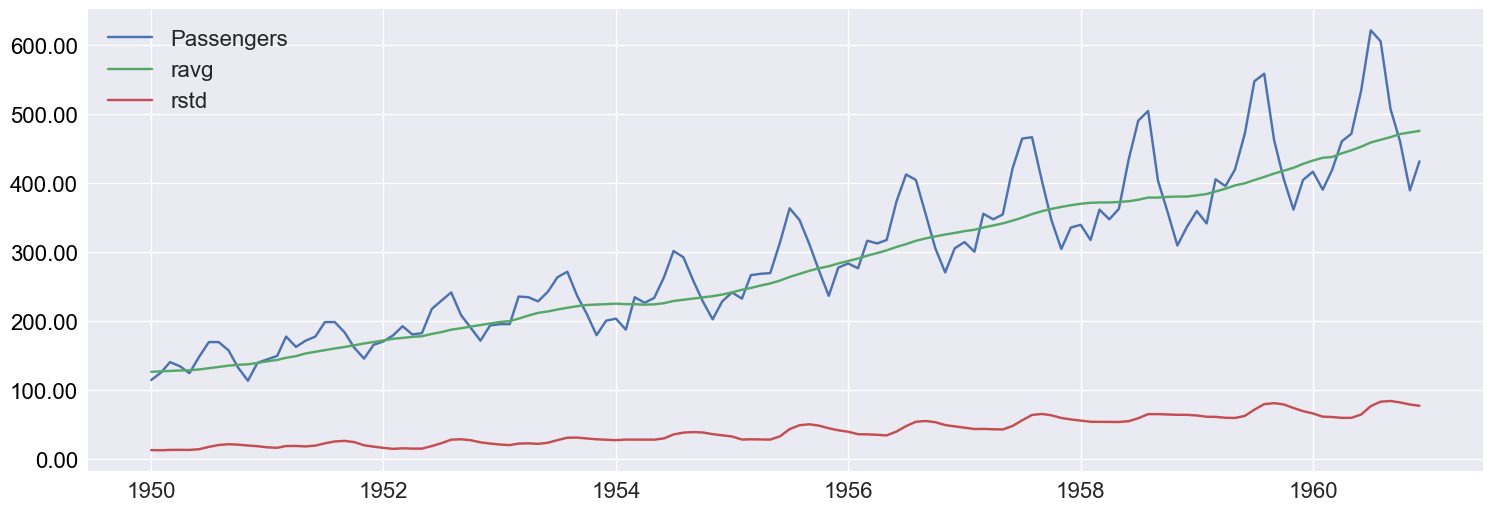

In [91]:
#data
#https://www.kaggle.com/datasets/rakannimer/air-passengers?resource=download

df_airp = pd.read_csv("../data/AirPassengers.csv", parse_dates = ["Month"]).set_index("Month")
# add exogenous variables ... rolling nmean, rolling std, month no.
Nr=12
df_airp["ravg"] = df_airp["Passengers"].rolling(window=Nr).mean()  
df_airp["rstd"] = df_airp["Passengers"].rolling(window=Nr).std()
df_airp=df_airp.iloc[Nr:] # toss out first Nr rows since they will be NA due to rolling mean and std
df_airp["month_no"] = df_airp.index.month

print("df_airp")
display(df_airp.head())

# rows with NA
print("rows with NA")
display(df_airp[df_airp.isna().any(axis=1)])


bp.lineplot(df_airp.reset_index(), x="Month", y=["Passengers","ravg","rstd"], figsize=(18,6))

SARIMAX sliding 5 day forecast

dfXY


,Passengers,ravg,rstd,month_no
Month,,,,
1950-01-01,115,126.916667,13.453342,1
1950-02-01,126,127.583333,13.166475,2
1950-03-01,141,128.333333,13.686977,3
1950-04-01,135,128.833333,13.822467,4
1950-05-01,125,129.166667,13.663710,5



metrics = {'Passengers_pred': {'RMSE': 16.797018987925536, 'MAE': 15.382124846502904}}


,Passengers,ravg,rstd,month_no,Passengers_train,Passengers_test,Passengers_pred,Passengers_pred_error,Passengers_pred_lower,Passengers_pred_upper
Month,,,,,,,,,,
1960-08-01,606,463.333333,83.630500,8,NaN,606.0,630.076032,-24.076032,606.389177,631.549379
1960-09-01,508,467.083333,84.617276,9,NaN,508.0,519.160167,-11.160167,495.473311,520.633514
1960-10-01,461,471.583333,82.541954,10,NaN,461.0,452.098118,8.901882,428.411263,453.571466
1960-11-01,390,473.916667,79.502382,11,NaN,390.0,413.103090,-23.103090,389.416235,414.576438
1960-12-01,432,476.166667,77.737125,12,NaN,432.0,441.669454,-9.669454,417.982599,443.142802


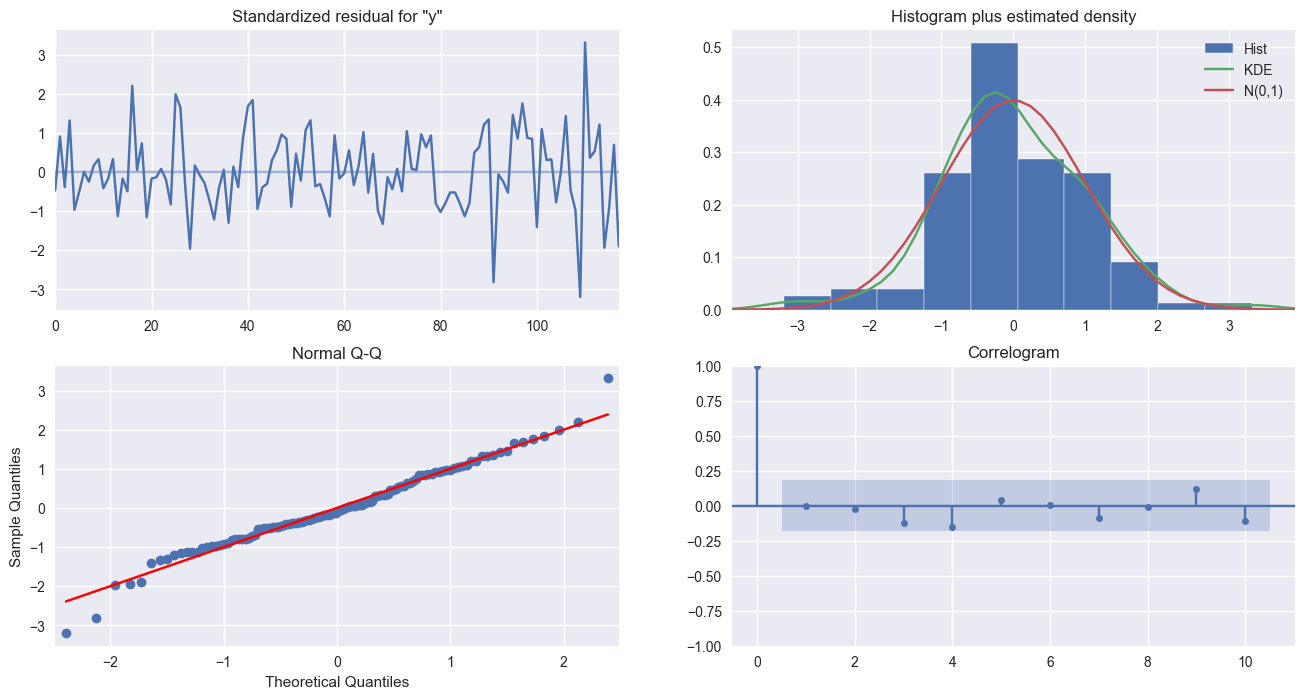

In [92]:
Npred=5
dfXY = df_airp
print('dfXY')
display(dfXY.head())

tswin_params = {
    "Npred":Npred,
    "Nlags":5,
    "minmax" :(0,None)}  

cm_parameters = {
    "model":"sarimax",
    "order":(2,1,0),
    "seasonal_order":(0,1,0,12)
}

y = "Passengers"
sf_sarimax = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    tswin_parameters=tswin_params,)

df_pred_sarimax = sf_sarimax.forecast(dfXY)


print(f'\nmetrics = {sf_sarimax.metrics}')
dfXY_pred_sarimax = dfXY.join(df_pred_sarimax)
display(dfXY_pred_sarimax.tail())

sf_sarimax.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

direct use of SARIMAX for comparision. 1 period forward forecast

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = "Passengers"
exog_vars = ["ravg","rstd","month_no"]
sarima_model=SARIMAX(dfXY[:-1][y].values, exog=dfXY[:-1][exog_vars].values, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12),
                    enforce_stationarity=False, enforce_invertibility=False)


ypred = sarima_model_fit.forecast(exog=dfXY.tail(1)[exog_vars].values)[0]
print("y_pred =",y_pred)
print("y_actual =",dfXY.tail(1)[y].values[0])

y_pred = 524.253124387115
y_actual = 432


### Auto ARIMA

In [78]:
Npred=3
dfXY = df_airp
print('dfXY')
display(dfXY.head())

tswin_params = {
    "Npred":Npred,
    "Nlags":5,
    "Nhorizon":3,
    "minmax" :(0,None)
    }  

cm_parameters = {
    "model":"auto_arima",
    "d":None, # let the auto search determine d
    "start_p":1,
    "start_q":1,
    "seasonal":True ,
    "D":None, # let auto search determine D
    "m":12, # 12, period (i.e., month) seasonality period
    "start_P":1,
    "start_Q":1,
    "error_action":"ignore", # don't want to know if order does not work
    "suppress_warnings":True, # don't want convergence warnings
    "stepwise":True # stepwise search

}

y = "Passengers"
sf_autoarima = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    tswin_parameters=tswin_params,)

df_pred_autoarima = sf_autoarima.forecast(dfXY)


print(f'\nmetrics = {sf_autoarima.metrics}')
dfXY_pred_autoarima = dfXY.join(df_pred_autoarima)
display(dfXY_pred_autoarima.tail())




dfXY


,Passengers,ravg,rstd,month_no
Month,,,,
1950-01-01,115,126.916667,13.453342,1
1950-02-01,126,127.583333,13.166475,2
1950-03-01,141,128.333333,13.686977,3
1950-04-01,135,128.833333,13.822467,4
1950-05-01,125,129.166667,13.663710,5


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=920.195, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=910.453, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=910.912, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=909.447, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=910.699, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=911.404, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=911.351, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=909.840, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=911.417, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.634 seconds
n_periods =  3

metrics = {'Passengers_pred': {'RMSE': 15.45114192396711, 'MAE': 14.765337215463054

,Passengers,ravg,rstd,month_no,Passengers_train,Passengers_test,Passengers_pred,Passengers_pred_error,Passengers_pred_lower,Passengers_pred_upper
Month,,,,,,,,,,
1960-08-01,606,463.333333,83.630500,8,606.0,NaN,NaN,NaN,NaN,NaN
1960-09-01,508,467.083333,84.617276,9,508.0,NaN,NaN,NaN,NaN,NaN
1960-10-01,461,471.583333,82.541954,10,NaN,461.0,452.642947,8.357053,461.0,461.0
1960-11-01,390,473.916667,79.502382,11,NaN,390.0,407.436257,-17.436257,390.0,390.0
1960-12-01,432,476.166667,77.737125,12,NaN,432.0,450.502702,-18.502702,432.0,432.0


direct use of auto_arima for comparison

In [94]:
# autoarima tutorial references
# https://alkaline-ml.com/pmdarima/1.3.0/tips_and_tricks.html
# https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

import pmdarima as pm

y=["Passengers"]
exog_vars = ["ravg","rstd","month_no"]

arima_model = pm.auto_arima(dfXY.iloc[:-Npred][y], exogenous = dfXY.iloc[:-Npred][exog_vars] , 
                         start_p=1, start_q=1, d=None,
                         test = "adf", # test ADF (augmented Dickey-Fuller) for stationarity
                         #max_p=5, max_q=5, 
                         max_q=None,
                         seasonal=True, #set to seasonal 
                         #start_P=0, start_Q=1,
                         start_Q=0,
                         max_Q=None,
                         m=12, # frequncy of the cycle 12 months
                         D=None, #order of the seasonal differencing ... will be estimated when seasonality = True
                         trace=True,   # print model AIC 
                         error_action='ignore',  # don't want to know if an order does not work
                         suppress_warnings=True, # don't want convergence warnings
                         stepwise=True # stepwise search
                                                      )

arima_model.fit(dfXY.iloc[:-Npred][y], exogenous = dfXY.iloc[:-Npred][exog_vars])

n_periods=dfXY.tail(Npred).shape[0]
ypred=arima_model.predict(n_periods,dfXY.tail(Npred)[exog_vars])

print(ypred)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=894.111, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=901.764, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=892.330, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=893.313, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=891.177, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=892.544, Time=0.13 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=892.968, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=892.760, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=892.175, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=894.718, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=892.976, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.563 seconds
1960-08-01    629.444446
1960-09-01    534.593715
1960-10-01    478.222234
1960-11-01    43

## SK Learn Models - XGBOOST

In [95]:
from xgboost import XGBRegressor

### Superstore Data

Often data needs pre-process to aggregate and clean the data so that it is suitable for forecasting. The data for these examples is derived from the Superstore dataset avaliable [here](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls). In order not to over complicate this notebook we will not demonstrate all the pre-processing here. Howevver, the EDA/pre-procssing notebook is found at the following link - [pre-processing notebook](https://github.com/Aljgutier/sforecast/blob/main/docs/forecast_EDA_Superstore.ipynb)


Data pre-processing, prior to loading the data below, include the following steps
* contiguous dates - ensure that there are no missing dates
* the data is aggregated to sub category - the original dateset containes categories, sub-categories, and product ids. Below, we will further aggregate to category.

The output of the preprocesing (i.e., data loaded below) is avaialable in this github repo, [pre-processed data](https://github.com/Aljgutier/sforecast/blob/main/data/Superstore_subcatsales_2017_cdp.csv).

In [96]:
df_sales = pd.read_csv("../data/Superstore_subcatsales_2017_cdp.csv", parse_dates = ["Order Date"])
display(df_sales.head(10))

print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N rows (sales) = {df_sales.shape[0]}')
print( f'N Sub-Catetories = {df_sales.groupby("Sub-Category")["Sales"].count().count()} ')

,Order Date,Category,Sub-Category,Sales,Quantity
0,2014-01-03,Office Supplies,Paper,16.448,2.0
1,2014-01-04,Office Supplies,Labels,11.784,3.0
2,2014-01-04,Office Supplies,Binders,3.540,2.0
3,2014-01-04,Office Supplies,Paper,0.000,0.0
4,2014-01-04,Office Supplies,Storage,272.736,3.0
5,2014-01-05,Office Supplies,Labels,0.000,0.0
6,2014-01-05,Office Supplies,Binders,0.000,0.0
7,2014-01-05,Office Supplies,Paper,0.000,0.0
8,2014-01-05,Office Supplies,Art,19.536,3.0
9,2014-01-05,Office Supplies,Storage,0.000,0.0


date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N rows (sales) = 24431
N Sub-Catetories = 17 


### Aggregate to Category Time-Series


* aggregate category sales by date
* three categories - office supplies, furniture, technology
* lineplots to observe the timeseries

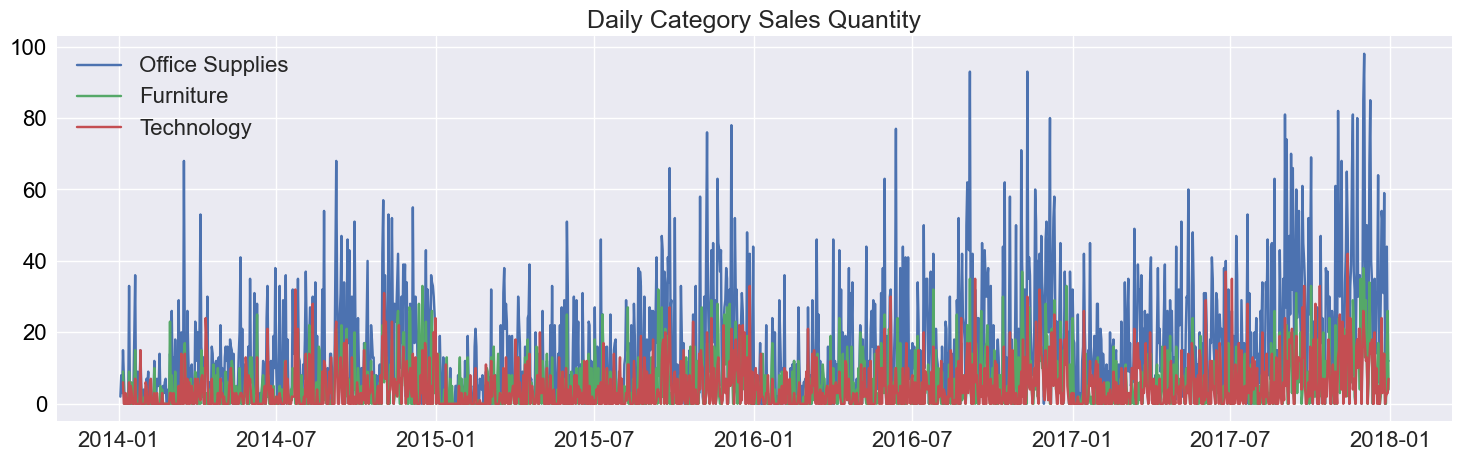

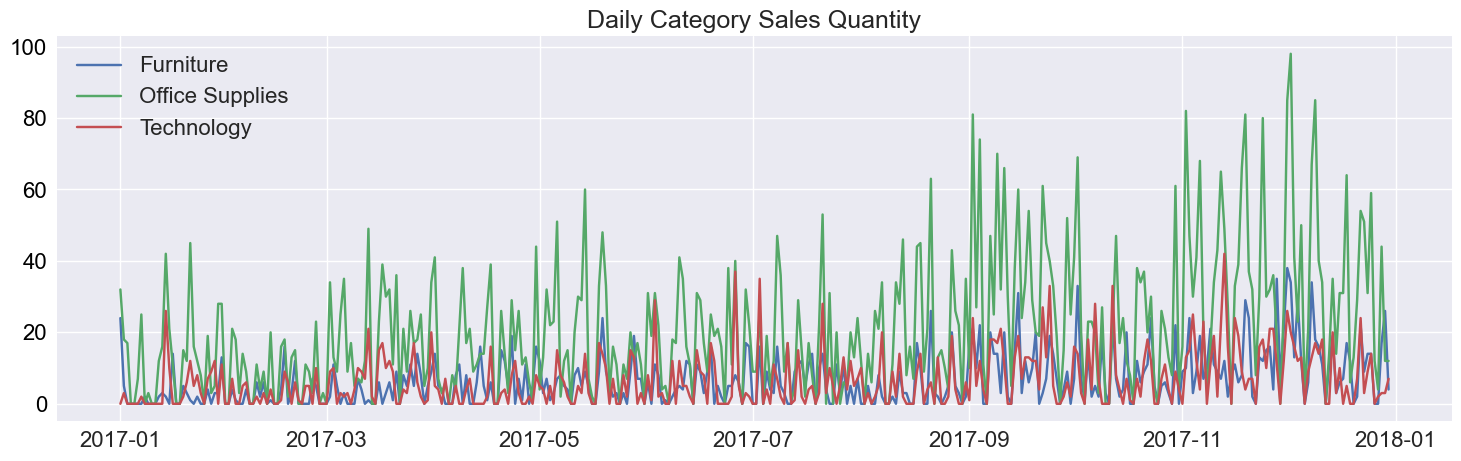

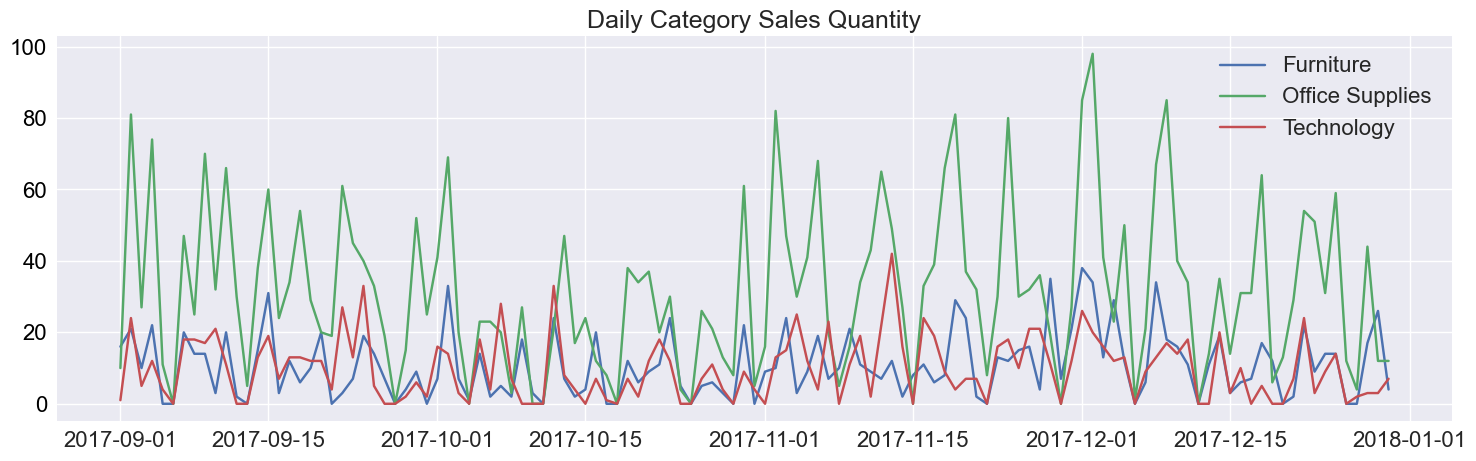

In [97]:
aggs = {
    "Sales":"sum",
    "Quantity":"sum"  
}

df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()
df_catsales.head(10)



bp.lineplot(df_catsales,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,1,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,9,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" ,
            title = "Daily Category Sales Quantity", figsize=(18,5))

### Wide (Multivariate) Format


* Pivot to wide format - time (index or colum) with all observation and co-variates in corresponding columns.
* Wide format will be especially useful for accounting for exogenous variables and covariates.
* We are interested in forecasting unit sales volume. For these examples, we do not need the sales revenue columns

In [98]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols

dp = "Order Date" # demand period

# note that the demand period (dp) = "Order Date" becomes the index
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 
dfXYw = dfXYw.fillna(0)

dfXYw.head()

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2014-01-03,0.0,2.0,0.0,0.000,16.448,0.00
2014-01-04,0.0,8.0,0.0,0.000,288.060,0.00
2014-01-05,0.0,3.0,0.0,0.000,19.536,0.00
2014-01-06,9.0,15.0,6.0,2573.820,685.340,1147.94
2014-01-07,3.0,7.0,0.0,76.728,10.430,0.00


### Univariate Forecast

Univariate forecast considers only one variable
  * 30 day sliding forecast, Npred = 30 days
  * Predict horizon, Nhorizon = 1. Model is retrained after every prediction , to account for new observation after sliding over by 1.
  * y = "Quantity_Furniture"
  * The univariate (y) will be lagged over 40 days.
  * ML model = XGBoost Model
  * join the forecast resul with the input DataFrame dfXY
  * data scaling (normalization) - by default the sliding model will scale the input variables with the SKlearn minmax scaler. However, there is an option to scale with the StandardScaler. See the [sforecast](https://sforecast.readthedocs.io/en/latest/) documentaton for more information.
  * RMSE result = 10.94

Next, after the univariate forecast, are multivariate forecasts
   * Mutlivariate forecast single output(Quantity_Furniture),  RMSE (Quantity_Furniture)  = 9.92
   * Multivaritate forecast multiple output (Furniture, Office Supplies, Technology), with Nhorizon = 5, RMSE (Quantity_Furniture) = 10.23


In [99]:

dfXY = dfXYw[["Quantity_Furniture"]]

print('dfXY')
display(dfXY.head())

tswin_params = {
    "Npred":30,
    "Nhorizon":1,
    "Nlags":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfuv = sf.sforecast(y = y, tswin_parameters=tswin_params,model=xgb_model,model_type="sk")

df_pred_uv = sfuv.forecast(dfXY)


print(f'\nmetrics = {sfuv.metrics}')
dfXY_pred_uv = dfXY.join(df_pred_uv)
display(dfXY_pred_uv)


dfXY


,Quantity_Furniture
Order Date,
2014-01-03,0.0
2014-01-04,0.0
2014-01-05,0.0
2014-01-06,9.0
2014-01-07,3.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.93991802246071, 'MAE': 8.818413734436035}}


,Quantity_Furniture,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,
2014-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-26,0.0,NaN,0.0,8.522676,-8.522676,0.000000,26.245546
2017-12-27,0.0,NaN,0.0,5.819362,-5.819362,0.000000,23.542233
2017-12-28,17.0,NaN,17.0,10.800791,6.199209,0.698584,28.523662


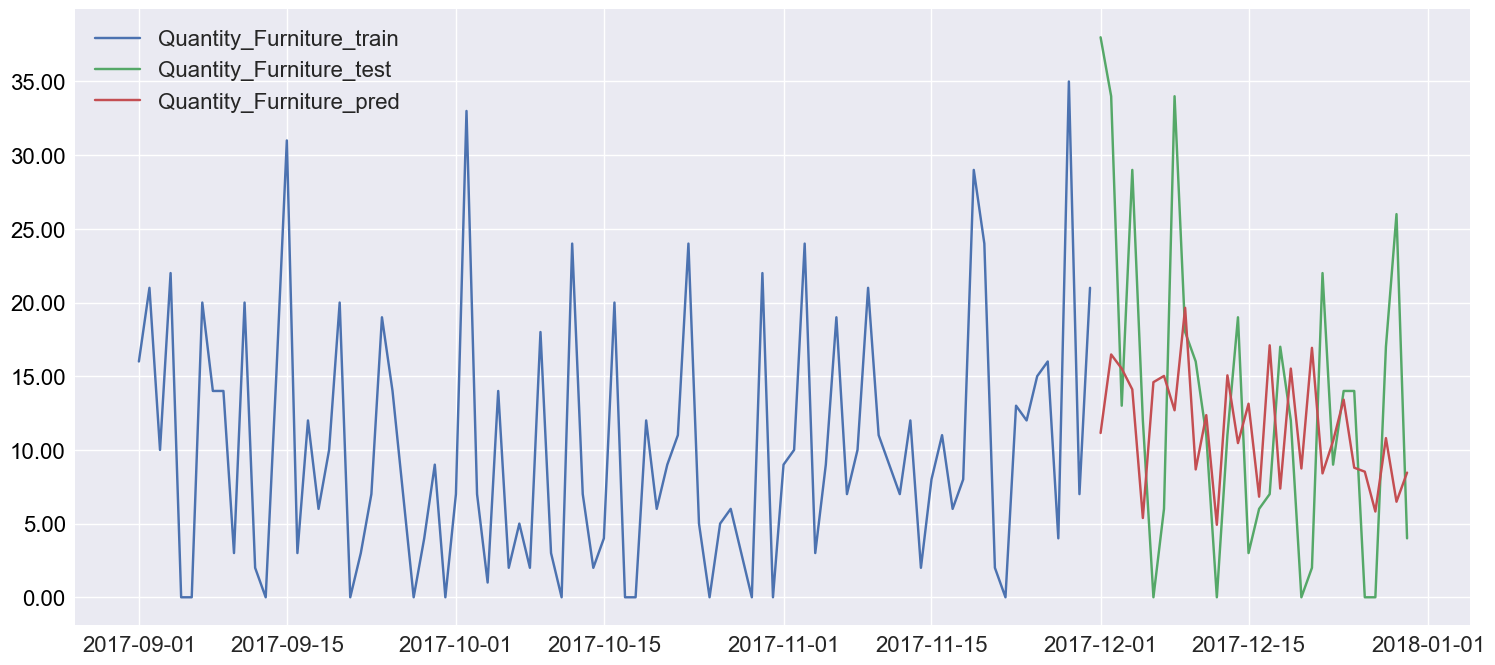

In [100]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuv = dfXY_pred_uv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfuv[dfuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

### Multivariate Forecast one Output


* this case is similar to the previous one, but also includes the covariates in the dfXY dataset
* initialize the sliding window model as before
* we must declare the covariates so that they are accounted for properly - unlagged covariates are not included in the training set
* we have a improved forecast accuracy for y = Quantity_Furniture: RMSE': 9.83, 'MAE': 7.36
* when comparing the previous example's lineplot we notice improved accuracy. In this example the predicted line follows the actual ("test") line a little more closely. 

In [107]:
dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]
y = ["Quantity_Furniture"]
print('dfXY',end="")
display(dfXY.head())
Npred = 30

tswin_params = {
    "Npred":Npred,
    "Nhorizon":1,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfuvc = sf.sforecast(y = y, tswin_parameters=tswin_params,model=xgb_model, model_type="sk")
df_pred_uvc = sfuvc.forecast(dfXY)

print(f'\nmetrics = {sfuvc.metrics}')
dfXY_pred_uvc = dfXY.join(df_pred_uvc)
display(dfXY_pred_uvc)

dfXY

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 9.826672736184616, 'MAE': 7.359953657786051}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,NaN,0.0,6.055835,-6.055835,0.000000,19.622014
2017-12-27,0.0,4.0,2.0,NaN,0.0,2.989914,-2.989914,0.000000,16.556093
2017-12-28,17.0,44.0,3.0,NaN,17.0,18.785179,-1.785179,11.204631,32.351358


In [102]:
sfuvc.dfXYfc.head()

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_m1,Quantity_Office Supplies_m1,Quantity_Technology_m1,Quantity_Furniture_m2,Quantity_Office Supplies_m2,Quantity_Technology_m2,Quantity_Furniture_m3,...,Quantity_Technology_m37,Quantity_Furniture_m38,Quantity_Office Supplies_m38,Quantity_Technology_m38,Quantity_Furniture_m39,Quantity_Office Supplies_m39,Quantity_Technology_m39,Quantity_Furniture_m40,Quantity_Office Supplies_m40,Quantity_Technology_m40
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-02-12,2.0,0.000000,0.000000,0.263158,0.122449,0.071429,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.000000,0.032258,0.000000,0.000000,0.086022,0.000000,0.000000,0.021505,0.000000
2014-02-13,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.263158,0.122449,0.071429,0.000000,...,0.000000,0.243243,0.161290,0.142857,0.000000,0.032258,0.000000,0.000000,0.086022,0.000000
2014-02-14,0.0,0.071429,0.071429,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.263158,...,0.000000,0.081081,0.075269,0.000000,0.243243,0.161290,0.142857,0.000000,0.032258,0.000000
2014-02-15,0.0,0.051020,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.052632,...,0.071429,0.000000,0.000000,0.000000,0.081081,0.075269,0.000000,0.243243,0.161290,0.142857
2014-02-16,0.0,0.051020,0.000000,0.000000,0.051020,0.000000,0.000000,0.071429,0.071429,0.000000,...,0.000000,0.000000,0.021505,0.071429,0.000000,0.000000,0.000000,0.081081,0.075269,0.000000


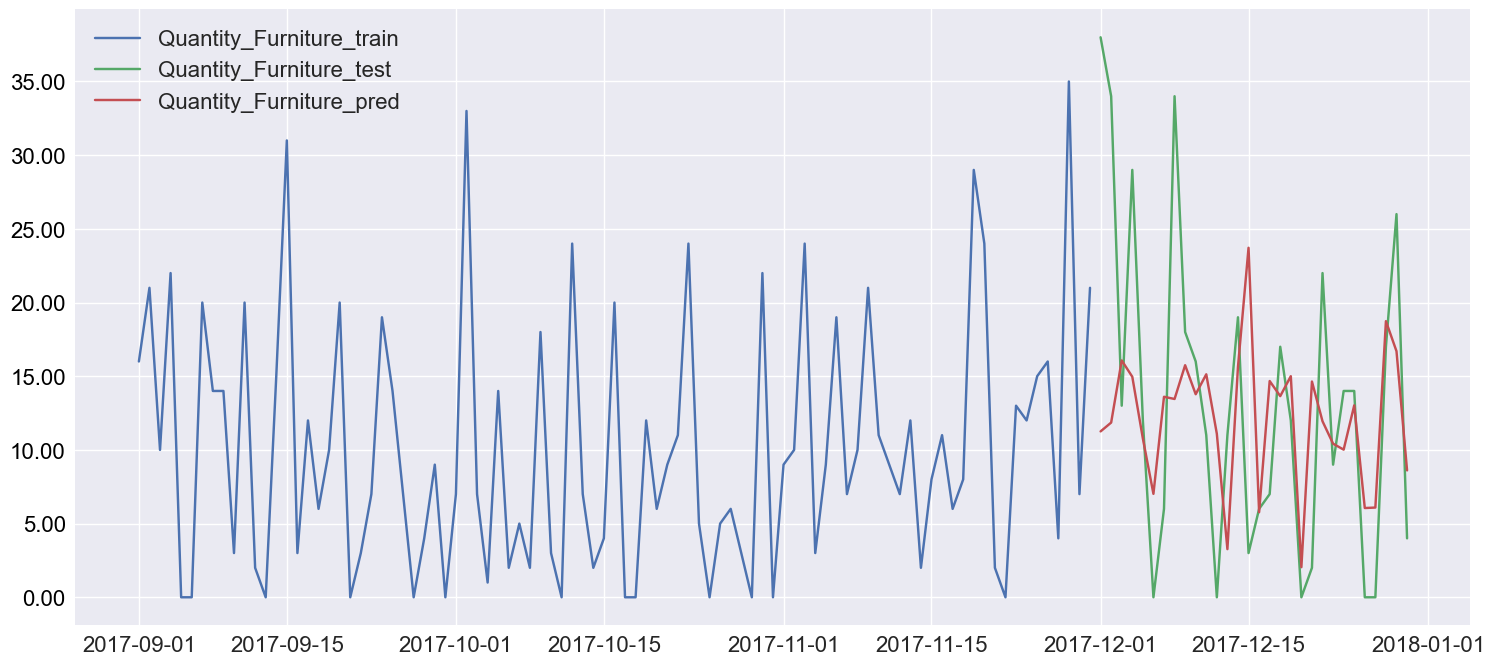

In [103]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuvc = dfXY_pred_uvc.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfuvc[dfuvc["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8))

### Multivariate Forecast Multiple Output, Nhorizon = 5

* This case is again very similar to the previous examples, with the difference that the forecast horizon is 5 periods between model re-training
* Again we inclue the co-variate variables but now we also forecast the co-variates
* In this case, sforecast loops through these variables and creates the forecasts
* Note that for more advanced types of models, such as deep-learning models the multivarites forecasts can be generated simultaneously
* We display the upper and lower prediction bounds, included with the prediction output.

In [108]:
dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]


print('dfXY',end="")
display(dfXY.head())

y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Npred = 30


# sliding forecast inputs
tswin_params = {
    "Npred":Npred,
    "Nhorizon":5,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 


xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

# sliding forecast model and forecast
sfmv = sf.sforecast(y = y, tswin_parameters=tswin_params,model=xgb_model,model_type="sk")
df_pred_mv = sfmv.forecast(dfXY)


print(f'\nmetrics = {sfmv.metrics}')
dfXY_pred_mv = dfXY.join(df_pred_mv)
display(dfXY_pred_mv)

dfXY

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.232084257594677, 'MAE': 7.569141944249471}, 'Quantity_Office Supplies_pred': {'RMSE': 24.50682143220817, 'MAE': 18.83777240117391}, 'Quantity_Technology_pred': {'RMSE': 7.870712541957454, 'MAE': 5.98594374259313}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,Quantity_Office Supplies_train,...,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,NaN,0.0,6.055835,-6.055835,0.000000,19.541523,NaN,...,30.671810,-18.671810,14.792501,51.433277,NaN,0.0,12.978919,-12.978919,0.000000,20.638935
2017-12-27,0.0,4.0,2.0,NaN,0.0,6.088521,-6.088521,0.000000,22.189593,NaN,...,8.742569,-4.742569,0.000000,49.256931,NaN,2.0,3.083239,-1.083239,0.000000,18.937561
2017-12-28,17.0,44.0,3.0,NaN,17.0,18.736565,-1.736565,16.332211,32.875791,NaN,...,26.361879,17.638121,26.465316,52.917364,NaN,3.0,11.969485,-8.969485,1.343812,15.760163


plot the observations, predicted output, and test (observations during corresponding to the predictions)

illustrate the confidence interval around the predictions. Sforecast defaults to 80% confidence periods, however the desired confidence interval can be specified as an input parameter.

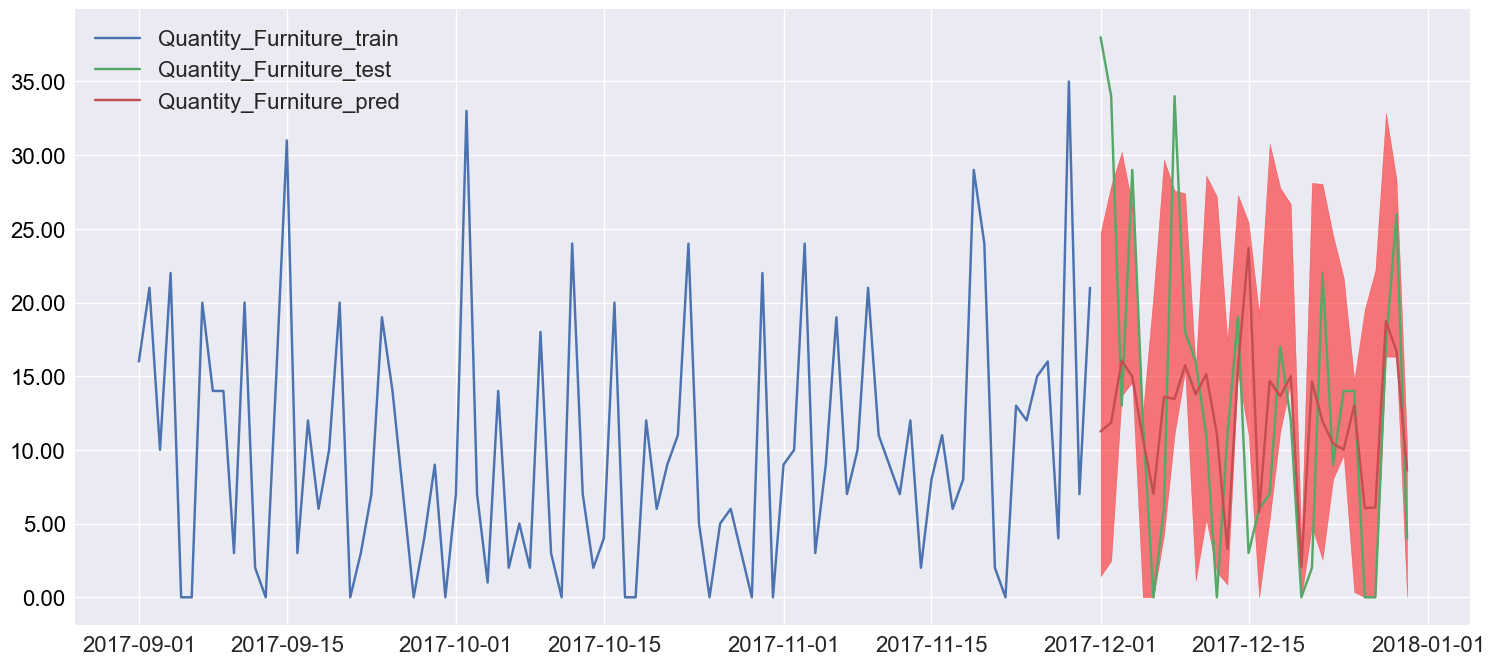

In [109]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfmv = dfXY_pred_mv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfmv[dfmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , yfb=yfillbetween, figsize=(18,8) , legend=True)

## 3. TensorFlow - Sliding Forecast, M5 Sales 7 Items

In [6]:
from sklearn.preprocessing import LabelEncoder

### TensorFlow Imports

In [16]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

### Load Data, M5 Sales 20 items

In [17]:
df_m5sales20 = pd.read_csv("../data/m5_sales_7_items_events_cci_wide.csv", parse_dates = ["date"])
df_m5sales20 = df_m5sales20.set_index("date")

# variable types
covars = [c for c in df_m5sales20.columns if "unit_sales_CA_1_" in c]
catvars = [ "weekday", "event_name_1","event_name_2"]
exogvars = [ "year", "month" , "week",  "snap_CA",  "CCI_USA"]
Ncatvars = len(catvars)
Ncovars = len(covars)
Nexogvars = len(exogvars)

# dfXY ... covars + exogvars + catvars
cols = covars+catvars+exogvars
dfXY = df_m5sales20[cols].copy()

# label Encoding
le_catvars = [ "le_"+c for c in catvars ] # label encoded category columns
le = LabelEncoder()
dfXY[le_catvars] =dfXY[catvars].apply(le.fit_transform)
print(f'N event_name_1 labels = {dfXY.groupby("event_name_1")["event_name_1"].count().index.size}')

# embedding dimensions
eindim = [dfXY[le_catvars].groupby(c)[c].count().index.size + 1 for c in le_catvars] # add 1 to the dim or err in TF
eoutdim = [np.rint(np.log2(x)).astype(int) for x in eindim]
print(f'eindim = {eindim}')
print(f'eoutdim = {eoutdim}')

# display dfXY
print(f'dfXY.shape = {dfXY.shape}')
print(f'\ndfXY.head = ')
display(dfXY.head())

N event_name_1 labels = 30
eindim = [8, 32, 5]
eoutdim = [3, 5, 2]
dfXY.shape = (1206, 18)

dfXY.head = 


,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416,unit_sales_CA_1_FOODS_2_FOODS_2_044,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418,unit_sales_CA_1_FOODS_3_FOODS_3_185,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219,unit_sales_CA_1_FOODS_3_FOODS_3_393,weekday,event_name_1,event_name_2,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,Saturday,NaN,NaN,2013,2,5,1,98.72734,2,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,Sunday,SuperBowl,NaN,2013,2,5,1,98.72734,3,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,Monday,NaN,NaN,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,Tuesday,NaN,NaN,2013,2,6,1,98.72734,5,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,Wednesday,NaN,NaN,2013,2,6,1,98.72734,6,30,3


### Univariate TF Forecast

##### Univariate Data

In [18]:
# y forecast variable
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030"]

# univariate data
print("dfXYm5 univariate")
dfXYuv = dfXY[y] 
display(dfXYuv.head())

dfXYm5 univariate


,unit_sales_CA_1_FOODS_3_FOODS_3_030
date,
2013-02-02,43.0
2013-02-03,33.0
2013-02-04,5.0
2013-02-05,14.0
2013-02-06,11.0


##### TF Model - Dense Network

In [19]:
# TensorFlow model with 3 hidden layers

Nlags=5
inputs = Input((Nlags,))
h1 = Dense(Nlags, activation='relu')(inputs)
h2 = Dense(20, activation='relu')(h1)
h3 = Dense(10, activation='relu')(h2)
output = Dense(1)(h3)
model_tf_dense = Model(inputs=inputs, outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense.compile(loss='mse', optimizer=optimizer)
print(model_tf_dense.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 20)                120       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None


2022-10-17 07:12:35.560048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### forecast

In [20]:


tswin_params = {
    "Npred":30,
    "Nhorizon":5,
    "Nlags":Nlags,
    "minmax" :(0,None)}  


tf_params = {
    "Nepochs_i": 100,
    "Nepochs_t": 100,
    "batch_size":100
    
}


sfuvtf = sf.sforecast(y = y, model_type="tf", tswin_parameters=tswin_params,model=model_tf_dense, tf_parameters=tf_params)

df_pred_uv = sfuvtf.forecast(dfXYuv)

print(f'\nmetrics = {sfuvtf.metrics}')
dfXY_pred_uvtf = dfXYuv.join(df_pred_uv)
display(dfXY_pred_uvtf.tail())


1/1 [==============================] - 0s 19ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 3.2890165214813436, 'MAE': 2.4783754189809164}}


,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_FOODS_3_FOODS_3_030_train,unit_sales_CA_1_FOODS_3_FOODS_3_030_test,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_error,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_lower,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_upper
date,,,,,,,
2016-05-18,7.0,NaN,7.0,7.161931,-0.161931,4.329058,8.680541
2016-05-19,11.0,NaN,11.0,7.110207,3.889793,5.538871,13.297699
2016-05-20,9.0,NaN,9.0,8.489532,0.510468,5.981940,10.138787
2016-05-21,9.0,NaN,9.0,8.478021,0.521979,4.790704,12.701193
2016-05-22,8.0,NaN,8.0,8.368402,-0.368402,3.069218,9.327663


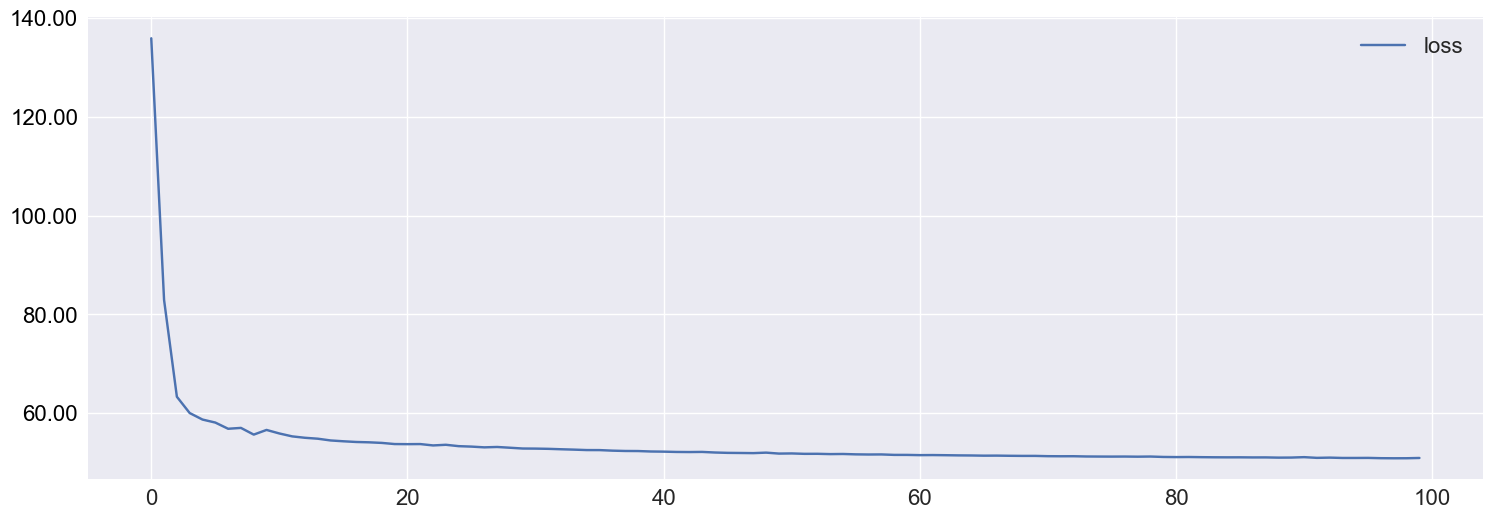

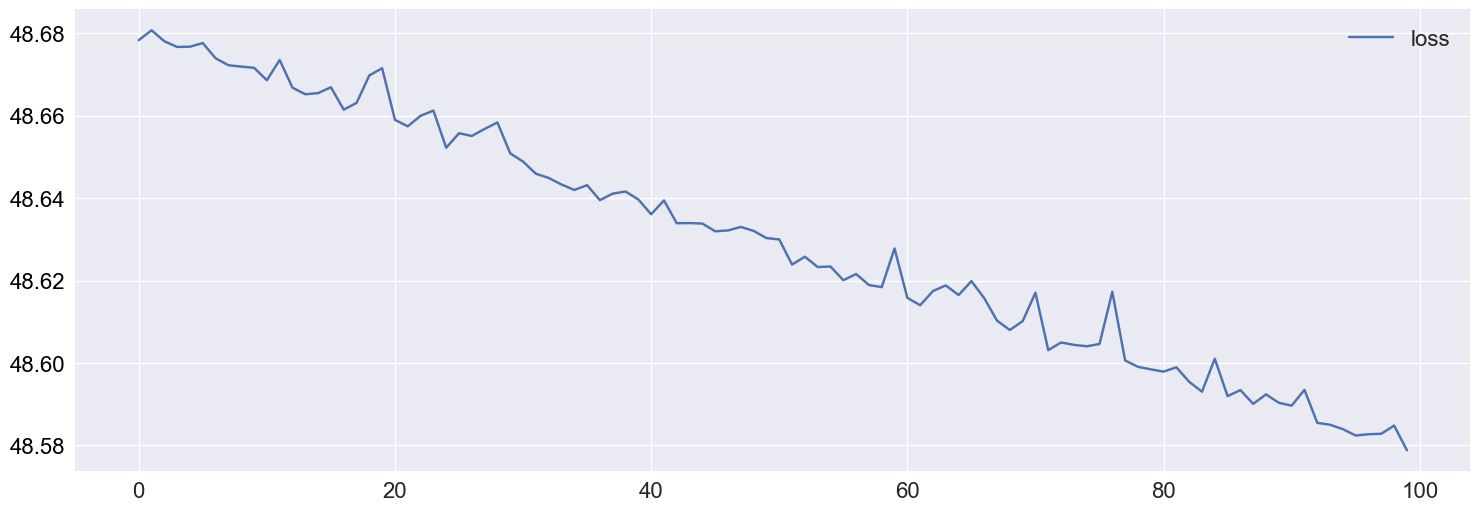

In [21]:
df_loss_i = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_i.history["loss"])), 
                                "loss":sfuvtf.history_i.history["loss"] })
bp.lineplot(df_loss_i, x ="epoch", y = "loss", figsize=(18,6) )

df_loss_t = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_t.history["loss"])), 
                                "loss":sfuvtf.history_t.history["loss"] })
bp.lineplot(df_loss_t, x ="epoch", y = "loss", figsize=(18,6) )

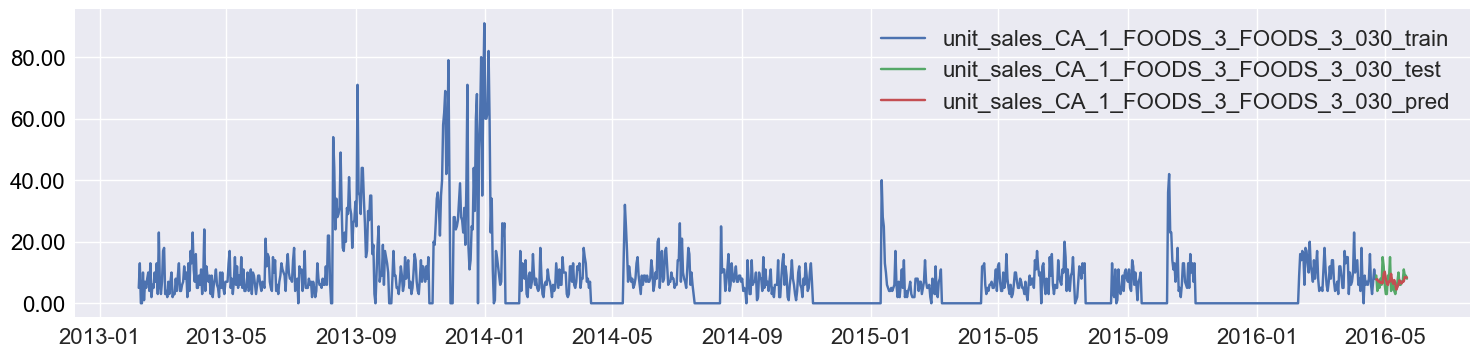

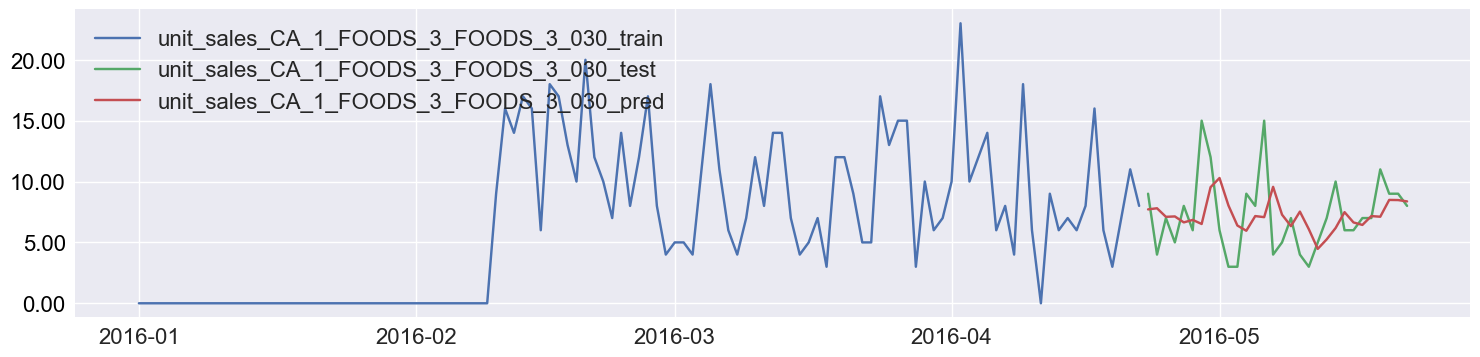

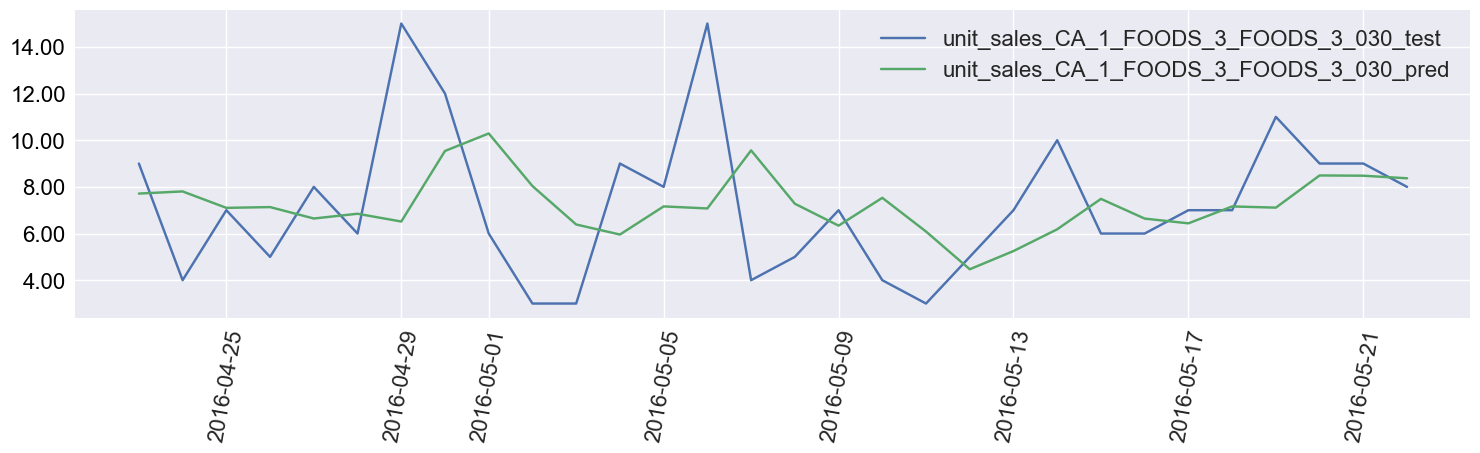

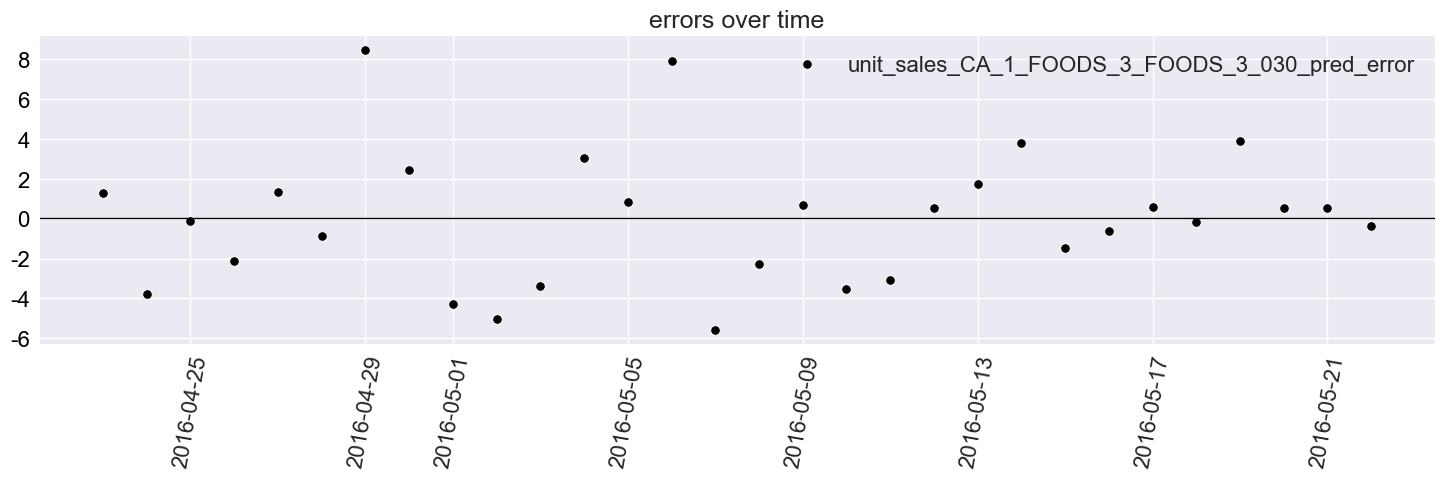

In [22]:
y = "unit_sales_CA_1_FOODS_3_FOODS_3_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_uvtf.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

error_avg =df[error].mean()

bp.lineplot(df, x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

d=datetime(2016,1,1)
bp.lineplot(df[df["date"]>=d], x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

bp.lineplot(df.tail(30), x="date", y=[ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

bp.lineplot(df.tail(30), x="date", y=error,  h_line = [error_avg], 
            y_axis_format=".0f",linestyle="None", marker="o", color="k", 
            title = "errors over time", x_tick_rotation=80,  figsize=(18,4))

### Univariate + Categorical Variables

#### data

In [23]:

# y forecast variable
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030"]
dfXYuvcat = dfXY[y+le_catvars]
display(dfXYuvcat.head())

,unit_sales_CA_1_FOODS_3_FOODS_3_030,le_weekday,le_event_name_1,le_event_name_2
date,,,,
2013-02-02,43.0,2,30,3
2013-02-03,33.0,3,26,3
2013-02-04,5.0,1,30,3
2013-02-05,14.0,5,30,3
2013-02-06,11.0,6,30,3


##### TF Model 
Dense Network (Xlags = univariate lags) + Embeddings (Categorical Variables)

In [24]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables)
Nlags = 5
Nconts = Nlags * Ncovars + Nexogvars # in general, lagged covars (does not include unlagged covars) + exogvars
Ndense = Nlags  # N continous/dense variables, in this case covars is 1 (univarate)
Nembout = sum(eoutdim)

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1c = Dense(Ndense, activation='relu')(cont_inputs)


# embeddings, cat vars

cat_inputs_list = [ Input((1,)) for c in range(Ncatvars) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1c]+emb_flat_list)

# dense reduction layers
Nh1_comb = Ndense + Nembout  # 
h1_comb = Dense(Nh1_comb, activation='relu')(combined)
Nh2_comb = np.rint(Nh1_comb/2).astype(int)
h2_comb = Dense(Nh2_comb, activation='relu')(h1_comb)

# output
output = Dense(1)(h2_comb)  # linear activation ... linear combination 

# build model
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)
print(model_tf_dense_emb.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                            

##### Forecast

In [47]:
tswin_params = {
    "Npred":2,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "catvars":le_catvars 
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}


sfccm5 = sf.sforecast(y = y, model_type="tf", tswin_parameters=tswin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred_ccm5 = sfccm5.forecast(dfXYuvcat)

print(f'\nmetrics = {sfccm5.metrics}')
dfXY_pred_ccm5 = dfXY.join(df_pred_ccm5)
display(dfXY_pred_ccm5.tail())


1/1 [==============================] - 0s 19ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 0.9264759237615604, 'MAE': 0.7322812080383301}}


,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416,unit_sales_CA_1_FOODS_2_FOODS_2_044,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418,unit_sales_CA_1_FOODS_3_FOODS_3_185,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219,unit_sales_CA_1_FOODS_3_FOODS_3_393,weekday,event_name_1,event_name_2,...,CCI_USA,le_weekday,le_event_name_1,le_event_name_2,unit_sales_CA_1_FOODS_3_FOODS_3_030_train,unit_sales_CA_1_FOODS_3_FOODS_3_030_test,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_error,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_lower,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,Wednesday,NaN,NaN,...,100.7612,6,30,3,7.0,NaN,NaN,NaN,NaN,NaN
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,Thursday,NaN,NaN,...,100.7612,4,30,3,11.0,NaN,NaN,NaN,NaN,NaN
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,Friday,NaN,NaN,...,100.7612,0,30,3,9.0,NaN,NaN,NaN,NaN,NaN
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,Saturday,NaN,NaN,...,100.7612,2,30,3,NaN,9.0,9.164723,-0.164723,7.978396,8.886488
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,Sunday,NaN,NaN,...,100.7612,3,30,3,NaN,8.0,9.299839,-1.299839,8.113512,9.021604


### TF - Multivariate Single Output: Dense (exog + covariage lags) + Embeddings (categorical variables)

#### Data

In [48]:
# unit_sales_CA_1_FOODS_2_FOODS_2_044
# unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416
# unit_sales_CA_1_FOODS_3_FOODS_3_393
# y forecast variable
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030" ]
dfXYcovcatso = dfXY[covars+exogvars+le_catvars]
print(catvars)
print(exogvars)
print(dfXYcovcatso.shape)
display(dfXYcovcatso.head())

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416,unit_sales_CA_1_FOODS_2_FOODS_2_044,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418,unit_sales_CA_1_FOODS_3_FOODS_3_185,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219,unit_sales_CA_1_FOODS_3_FOODS_3_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,1,98.72734,2,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,1,98.72734,3,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,5,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,6,30,3


#### TF Model

In [50]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense = Nlags * Ncovars + Nexogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
#Ndense = Nlags  # N continous/dense variables, in this case covars is 1 (univarate)

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(1)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb_so = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_dense_emb_so.compile(loss='mse', optimizer=optimizer)



print(model_tf_dense_emb_so.summary())

Ndense = 40
Nemb = 3
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 40)]         0           []                               
                                                                       

#### Forecast

In [51]:
tswin_params = {
    "Npred":3,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}


sfcovembso = sf.sforecast(y = y, model_type="tf", tswin_parameters=tswin_params,model=model_tf_dense_emb_so, tf_parameters=tf_params)

df_pred_covcatso = sfcovembso.forecast(dfXYcovcatso)

print(f'\nmetrics = {sfcovembso.metrics}')
dfXY_pred_covcatso = dfXY.join(df_pred_covcatso)
display(dfXY_pred_covcatso.tail())

1/1 [==============================] - 0s 19ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 0.9474719165968075, 'MAE': 0.8786357243855795}}


,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416,unit_sales_CA_1_FOODS_2_FOODS_2_044,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418,unit_sales_CA_1_FOODS_3_FOODS_3_185,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219,unit_sales_CA_1_FOODS_3_FOODS_3_393,weekday,event_name_1,event_name_2,...,CCI_USA,le_weekday,le_event_name_1,le_event_name_2,unit_sales_CA_1_FOODS_3_FOODS_3_030_train,unit_sales_CA_1_FOODS_3_FOODS_3_030_test,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_error,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_lower,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,Wednesday,NaN,NaN,...,100.7612,6,30,3,7.0,NaN,NaN,NaN,NaN,NaN
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,Thursday,NaN,NaN,...,100.7612,4,30,3,11.0,NaN,NaN,NaN,NaN,NaN
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,Friday,NaN,NaN,...,100.7612,0,30,3,NaN,9.0,8.271969,0.728031,8.849384,9.512067
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,Saturday,NaN,NaN,...,100.7612,2,30,3,NaN,9.0,7.631886,1.368114,8.209301,8.871983
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,Sunday,NaN,NaN,...,100.7612,3,30,3,NaN,8.0,7.460238,0.539762,8.037654,8.700336


### TF Multivariate Multiple Ouput: Dense (exog + covariate lags) + Embeddings (categorical variables)

#### Data

In [52]:
# unit_sales_CA_1_FOODS_2_FOODS_2_044
# unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416
# unit_sales_CA_1_FOODS_3_FOODS_3_393
# y forecast variable
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_FOODS_2_FOODS_2_044" ]
dfXYcovcatmo = dfXY[covars+exogvars+le_catvars]
print(catvars)
print(exogvars)
print(dfXYcovcatmo.shape)
display(dfXYcovcatmo.head())

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416,unit_sales_CA_1_FOODS_2_FOODS_2_044,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418,unit_sales_CA_1_FOODS_3_FOODS_3_185,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219,unit_sales_CA_1_FOODS_3_FOODS_3_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,1,98.72734,2,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,1,98.72734,3,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,5,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,6,30,3


#### TF Model

In [53]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense = Nlags * Ncovars + Nexogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(y)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb_mo = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)



print(model_tf_dense_emb_mo.summary())

Ndense = 40
Nemb = 3
Nout = 2
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 40)]         0           []                               
                                                              

Forecast

In [54]:
ts_params = {
    "Npred":3,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

# define optimizer and compile ...compile before calling sf forcast or will start with pre-trained weights
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_dense_emb_mo.compile(loss='mse', optimizer=optimizer)

sfcovembmo = sf.sforecast(y = y, model_type="tf", tswin_parameters=tswin_params,model=model_tf_dense_emb_mo, tf_parameters=tf_params)

df_pred_covcatmo = sfcovembmo.forecast(dfXYcovcatmo)

print(f'\nmetrics = {sfcovembmo.metrics}')
dfXY_pred_covcatmo = dfXY.join(df_pred_covcatmo)
display(dfXY_pred_covcatmo.tail())

1/1 [==============================] - 0s 20ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 1.0334562035132635, 'MAE': 1.023033618927002}, 'unit_sales_CA_1_FOODS_2_FOODS_2_044_pred': {'RMSE': 1.5296454612382286, 'MAE': 1.4023007949193318}}


,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416,unit_sales_CA_1_FOODS_2_FOODS_2_044,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418,unit_sales_CA_1_FOODS_3_FOODS_3_185,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219,unit_sales_CA_1_FOODS_3_FOODS_3_393,weekday,event_name_1,event_name_2,...,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_error,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_lower,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_upper,unit_sales_CA_1_FOODS_2_FOODS_2_044_train,unit_sales_CA_1_FOODS_2_FOODS_2_044_test,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred_error,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred_lower,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,Wednesday,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,Thursday,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,Friday,NaN,NaN,...,8.178965,0.821035,9.052729,9.326608,NaN,0.0,0.762584,-0.762584,0.396326,2.786611
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,Saturday,NaN,NaN,...,7.836617,1.163383,8.710382,8.984260,NaN,3.0,0.774727,2.225273,0.408470,2.798755
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,Sunday,NaN,NaN,...,6.915318,1.084682,7.789082,8.062960,NaN,2.0,0.780954,1.219046,0.414696,2.804981


### TF Multivariate Multioutput:  LSTM (covariate lags) + Dense (exogenous vars) + Embeddings (categorical vars)

In [55]:
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_FOODS_2_FOODS_2_044" ]
dfXYcovexogcatmo = dfXY[covars+exogvars+le_catvars]
print(catvars)
print(exogvars)
print(dfXYcovexogcatmo.shape)
display(dfXYcovexogcatmo.head())

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416,unit_sales_CA_1_FOODS_2_FOODS_2_044,unit_sales_CA_1_FOODS_3_FOODS_3_030,unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418,unit_sales_CA_1_FOODS_3_FOODS_3_185,unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219,unit_sales_CA_1_FOODS_3_FOODS_3_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,1,98.72734,2,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,1,98.72734,3,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,5,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,6,30,3


In [58]:
# TensorFlow model ... LSTM (covar lags) Embeddings (categorical) + Dense (exog vars), Multiple Ouput
Nlags = 5
Nlstmsteps = Nlags   #lagged covars (does not include unlagged covars)
Nlstmfeatures = Ncovars
Ndense = Nexogvars # exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(y)

print("Nlstmsteps =",Nlstmsteps)
print("Nlstmfeatures =",Ncovars)
print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

lstm_inputs = Input((Nlstmsteps,Nlstmfeatures))   # number of inputs = Nlags , number of features = Ncovars
h1lstm= LSTM(Nlstmsteps, activation='relu', input_shape = (Nlstmsteps, Nlstmfeatures))(lstm_inputs) # nsteps = Nlags

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
dense_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(dense_inputs)

# embeddings, cat vars
emb_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,emb_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1lstm] +[h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Nlstmsteps*Nlstmfeatures + Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_lstm_dense_emb_mo = Model(inputs=[lstm_inputs, dense_inputs, emb_inputs_list], outputs=output)

# define optimizer and compile ..
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_lstm_dense_emb_mo.compile(loss='mse', optimizer=optimizer)

print(model_tf_lstm_dense_emb_mo.summary())

Nlstmsteps = 5
Nlstmfeatures = 7
Ndense = 5
Nemb = 3
Nout = 2
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 5, 7)]       0           []                               
                             

In [59]:
tswin_params = {
    "Npred":2,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars,
    "exogvars":exogvars
    }  

tf_params = {
    "Nepochs_i": 1000,
    "Nepochs_t": 400,
    "batch_size":100,
    "lstm": True
}



sfcovexogembmo = sf.sforecast(y = y, model_type="tf", tswin_parameters=ts_params,model=model_tf_lstm_dense_emb_mo, tf_parameters=tf_params)

df_pred_covexogcatmo =sfcovexogembmo.forecast(dfXYcovexogcatmo)

print(f'\nmetrics = {sfcovexogembmo.metrics}')
dfXY_pred_covexogcatmo = dfXY.join(df_pred_covexogcatmo)
display(df_pred_covexogcatmo.tail())

1/1 [==============================] - 0s 31ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 2.660617709476431, 'MAE': 2.6295151710510254}, 'unit_sales_CA_1_FOODS_2_FOODS_2_044_pred': {'RMSE': 1.7753900074793405, 'MAE': 1.7029072046279907}}


,unit_sales_CA_1_FOODS_3_FOODS_3_030_train,unit_sales_CA_1_FOODS_3_FOODS_3_030_test,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_error,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_lower,unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_upper,unit_sales_CA_1_FOODS_2_FOODS_2_044_train,unit_sales_CA_1_FOODS_2_FOODS_2_044_test,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred_error,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred_lower,unit_sales_CA_1_FOODS_2_FOODS_2_044_pred_upper
date,,,,,,,,,,,,
2016-05-18,7.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2016-05-19,11.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2016-05-20,9.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2016-05-21,NaN,9.0,5.964854,3.035146,8.269864,8.918874,NaN,3.0,0.794981,2.205019,2.096198,2.899578
2016-05-22,NaN,8.0,5.776116,2.223884,8.081126,8.730136,NaN,2.0,0.799205,1.200795,2.100422,2.903802


## Conclusions, Summary, and Next Steps
* This notebook has demonstrated the mechanics of using the sforecast package for sliding forecasts. 
* Sforecast and input DataFrame and model references for SK Learn and TensorFlow models. For classic models, the model parameters are input.
* The examples demonstrate how to run univariate, and multivariate sliding/expanding window forecasts including single output and multiple output, and also handling exogenous and categorical variables with TensorFlow.
* Sforecast significantly reduces the effort to manipulate the input data for all of these forecasting scenarios - lagged autoregressive variables, forecast horizons, sliding/expanding window, and properly setting the data loading for several common TensorFlow architectures.


## Readthedocs

### https://sforecast.readthedocs.io/en/latest/